In [21]:
import getpass

mypasswd = getpass.getpass()

········


In [22]:
import psycopg2
import numpy as np
from psycopg2.extensions import adapt, register_adapter, AsIs

# Then connects to the DB
connection = psycopg2.connect(database = 'capstonesp23olt05', 
                              user = 'ajmvgd', 
                              host = 'pgsql.dsa.lan',
                              password = mypasswd)

cursor = connection.cursor()

In [23]:
del mypasswd

## table names
    team
    game
    line
    player_weekly_stats
    player_yearly_stats

## Gathering data based on Quarterback Position

In [24]:
qb_statement = f"""
SELECT game.game_id, 
 game_divisional, gametime_year,
       gametime_week, gametime_weekday, gametime_time,
       away_team_id, home_team_id, 
       away_team_rest_days, home_team_rest_days,
       away_team_qb_id, home_team_qb_id, away_team_coach,
       home_team_coach, conditions_roof, conditions_surface,
       conditions_temp, conditions_wind,home_line_open,home_line_close
       ,case when home_line_open < 0 then 'home favored' when home_line_open > 0 then 'away favored' else 'even' end as open_team
       ,case when home_line_close < 0 then 'home favored' when home_line_close > 0 then 'away favored' else 'even' end as close_team
        ,-(home_line_open-home_line_close) as line_movement_from_open
        ,case when home_line_close<home_line_open AND home_line_open<0 then 'towards home'
        when home_line_open < home_line_close AND home_line_open < 0 then 'towards away' 
        when home_line_open < home_line_close AND home_line_close < 0 then 'towards away'
        when home_line_close < home_line_open AND home_line_close < 0 then 'towards home'
         when home_line_close > home_line_open AND home_line_close > 0 then 'towards away'
         when home_line_close < home_line_open AND home_line_close > 0 then 'towards home'
        else 'even' end as line_directionality,A.player_name as away_qb,H.player_name as home_qb
FROM game
INNER JOIN line ON game.game_id=line.game_id

JOIN (SELECT player_id,player_name
FROM player_weekly_stats
GROUP BY player_id,player_name) A ON game.away_team_qb_id=A.player_id

JOIN (SELECT player_id,player_name
FROM player_weekly_stats
GROUP BY player_id,player_name) H ON game.home_team_qb_id=H.player_id

WHERE game.game_type='REG' 
and game.gametime_year>=2020
and ((case when home_line_close<home_line_open AND home_line_open<0 then 'towards home'
        when home_line_open < home_line_close AND home_line_open < 0 then 'towards away' 
        when home_line_open < home_line_close AND home_line_close < 0 then 'towards away'
        when home_line_close < home_line_open AND home_line_close < 0 then 'towards home'
         when home_line_close > home_line_open AND home_line_close > 0 then 'towards away'
         when home_line_close < home_line_open AND home_line_close > 0 then 'towards home'
        else 'even' end)='towards away')
ORDER BY game_id 
"""
qbs = pd.read_sql_query(qb_statement, con=connection)
qbs.head(15)

,game_id,game_divisional,gametime_year,gametime_week,gametime_weekday,gametime_time,away_team_id,home_team_id,away_team_rest_days,home_team_rest_days,...,conditions_temp,conditions_wind,home_line_open,home_line_close,open_team,close_team,line_movement_from_open,line_directionality,away_qb,home_qb
0,2020_01_ARI_SF,1,2020,1,Sunday,16:25:00,3800,4500,7,7,...,66.0,6.0,-8.0,-6.5,home favored,home favored,1.5,towards away,Kyler Murray,Jimmy Garoppolo
1,2020_01_CLE_BAL,1,2020,1,Sunday,13:00:00,1050,325,7,7,...,76.0,5.0,-8.5,-7.0,home favored,home favored,1.5,towards away,Baker Mayfield,Lamar Jackson
2,2020_01_GB_MIN,1,2020,1,Sunday,13:00:00,1800,3000,7,7,...,NaN,NaN,-3.5,-2.5,home favored,home favored,1.0,towards away,Aaron Rodgers,Kirk Cousins
3,2020_01_HOU_KC,0,2020,1,Thursday,20:20:00,2120,2310,7,7,...,56.0,7.0,-10.0,-9.0,home favored,home favored,1.0,towards away,Deshaun Watson,Patrick Mahomes
4,2020_01_IND_JAX,1,2020,1,Sunday,13:00:00,2200,2250,7,7,...,80.0,3.0,7.0,8.0,away favored,away favored,1.0,towards away,Philip Rivers,Gardner Minshew
5,2020_01_LV_CAR,0,2020,1,Sunday,13:00:00,2520,750,7,7,...,81.0,5.0,1.0,3.0,away favored,away favored,2.0,towards away,Derek Carr,Teddy Bridgewater
6,2020_01_PIT_NYG,0,2020,1,Monday,19:15:00,3900,3410,7,7,...,71.0,5.0,4.0,5.5,away favored,away favored,1.5,towards away,Ben Roethlisberger,Daniel Jones
7,2020_01_TB_NO,1,2020,1,Sunday,16:25:00,4900,3300,7,7,...,NaN,NaN,-4.0,-3.5,home favored,home favored,0.5,towards away,Tom Brady,Drew Brees
8,2020_01_TEN_DEN,0,2020,1,Monday,22:10:00,2100,1400,7,7,...,79.0,10.0,-2.0,3.0,home favored,away favored,5.0,towards away,Ryan Tannehill,Drew Lock
9,2020_02_ATL_DAL,0,2020,2,Sunday,13:00:00,200,1200,7,7,...,NaN,NaN,-5.0,-3.5,home favored,home favored,1.5,towards away,Matt Ryan,Dak Prescott


The Goal was to show the Spread distribution per Away QB.

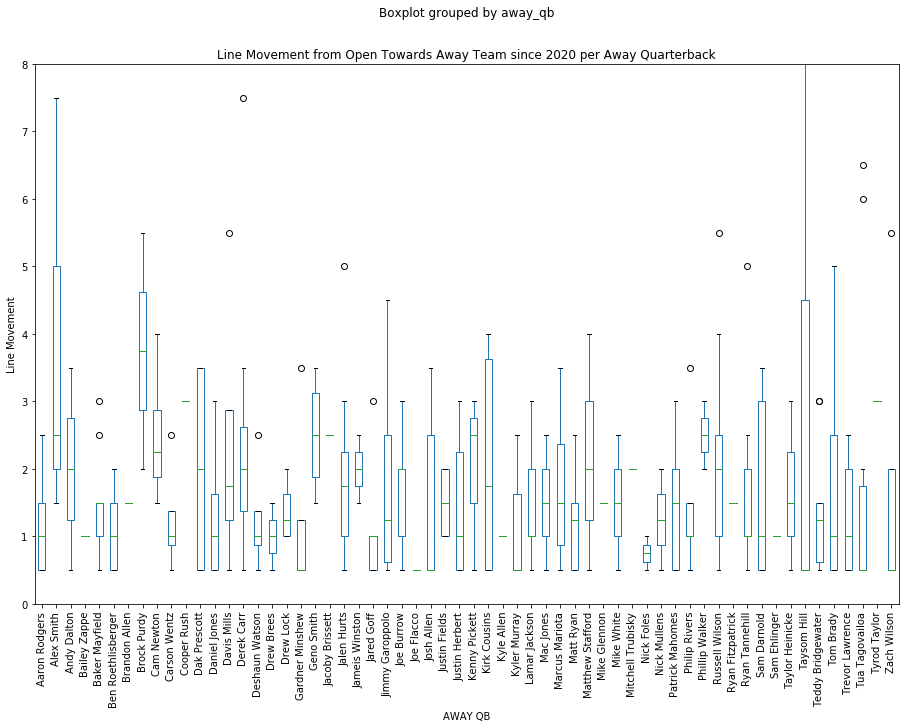

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
boxplot = qbs.boxplot(by = 'away_qb' ,column=['line_movement_from_open'],grid=False,figsize=(15,10)
                     ,rot=90)
boxplot.set_title('Line Movement from Open Towards Away Team since 2020 per Away Quarterback')
boxplot.set_xlabel('AWAY QB')
boxplot.set_ylabel('Line Movement')
boxplot.set_ylim(0,8)
plt.show()
plt.savefig('/dsa/groups/capstonesp2023/online/Team05/Line_Movement_from_Open_Towards_Away_Team_since2020_per_Away_QB.png')

In [26]:
# Here is the same query but for home quarterbacks
qb_statement_home = f"""
SELECT game.game_id, 
 game_divisional, gametime_year,
       gametime_week, gametime_weekday, gametime_time,
       away_team_id, home_team_id, 
       away_team_rest_days, home_team_rest_days,
       away_team_qb_id, home_team_qb_id, away_team_coach,
       home_team_coach, conditions_roof, conditions_surface,
       conditions_temp, conditions_wind,home_line_open,home_line_close
       ,case when home_line_open < 0 then 'home favored' when home_line_open > 0 then 'away favored' else 'even' end as open_team
       ,case when home_line_close < 0 then 'home favored' when home_line_close > 0 then 'away favored' else 'even' end as close_team
        ,-(home_line_open-home_line_close) as line_movement_from_open
        ,case when home_line_close<home_line_open AND home_line_open<0 then 'towards home'
        when home_line_open < home_line_close AND home_line_open < 0 then 'towards away' 
        when home_line_open < home_line_close AND home_line_close < 0 then 'towards away'
        when home_line_close < home_line_open AND home_line_close < 0 then 'towards home'
         when home_line_close > home_line_open AND home_line_close > 0 then 'towards away'
         when home_line_close < home_line_open AND home_line_close > 0 then 'towards home'
        else 'even' end as line_directionality,A.player_name as away_qb,H.player_name as home_qb
FROM game
INNER JOIN line ON game.game_id=line.game_id

JOIN (SELECT player_id,player_name
FROM player_weekly_stats
GROUP BY player_id,player_name) A ON game.away_team_qb_id=A.player_id

JOIN (SELECT player_id,player_name
FROM player_weekly_stats
GROUP BY player_id,player_name) H ON game.home_team_qb_id=H.player_id

WHERE game.game_type='REG' 
and game.gametime_year>=2020
and ((case when home_line_close<home_line_open AND home_line_open<0 then 'towards home'
        when home_line_open < home_line_close AND home_line_open < 0 then 'towards away' 
        when home_line_open < home_line_close AND home_line_close < 0 then 'towards away'
        when home_line_close < home_line_open AND home_line_close < 0 then 'towards home'
         when home_line_close > home_line_open AND home_line_close > 0 then 'towards away'
         when home_line_close < home_line_open AND home_line_close > 0 then 'towards home'
        else 'even' end)='towards home')
ORDER BY game_id 
"""
qbs_home = pd.read_sql_query(qb_statement_home, con=connection)
qbs_home.head(15)

,game_id,game_divisional,gametime_year,gametime_week,gametime_weekday,gametime_time,away_team_id,home_team_id,away_team_rest_days,home_team_rest_days,...,conditions_temp,conditions_wind,home_line_open,home_line_close,open_team,close_team,line_movement_from_open,line_directionality,away_qb,home_qb
0,2020_01_CHI_DET,1,2020,1,Sunday,13:00:00,810,1540,7,7,...,NaN,NaN,-1.5,-2.5,home favored,home favored,-1.0,towards home,Mitchell Trubisky,Matthew Stafford
1,2020_01_DAL_LA,0,2020,1,Sunday,20:20:00,1200,2510,7,7,...,NaN,NaN,2.5,2.0,away favored,away favored,-0.5,towards home,Dak Prescott,Jared Goff
2,2020_01_MIA_NE,1,2020,1,Sunday,13:00:00,2700,3200,7,7,...,70.0,8.0,-6.5,-7.0,home favored,home favored,-0.5,towards home,Ryan Fitzpatrick,Cam Newton
3,2020_01_NYJ_BUF,1,2020,1,Sunday,13:00:00,3430,610,7,7,...,67.0,15.0,-6.0,-6.5,home favored,home favored,-0.5,towards home,Sam Darnold,Josh Allen
4,2020_01_PHI_WAS,1,2020,1,Sunday,13:00:00,3700,5110,7,7,...,76.0,5.0,6.5,5.0,away favored,away favored,-1.5,towards home,Carson Wentz,Dwayne Haskins
5,2020_02_DEN_PIT,0,2020,2,Sunday,13:00:00,1400,3900,6,6,...,64.0,5.0,-5.5,-6.5,home favored,home favored,-1.0,towards home,Drew Lock,Ben Roethlisberger
6,2020_02_DET_GB,1,2020,2,Sunday,13:00:00,1540,1800,7,7,...,66.0,12.0,-5.5,-6.0,home favored,home favored,-0.5,towards home,Matthew Stafford,Aaron Rodgers
7,2020_02_LA_PHI,0,2020,2,Sunday,13:00:00,2510,3700,7,7,...,62.0,12.0,-1.0,-1.5,home favored,home favored,-0.5,towards home,Jared Goff,Carson Wentz
8,2020_03_DAL_SEA,0,2020,3,Sunday,16:25:00,1200,4600,7,7,...,63.0,3.0,-4.5,-5.0,home favored,home favored,-0.5,towards home,Dak Prescott,Russell Wilson
9,2020_03_LV_NE,0,2020,3,Sunday,13:00:00,2520,3200,6,7,...,73.0,8.0,-6.0,-6.5,home favored,home favored,-0.5,towards home,Derek Carr,Cam Newton


In [27]:
import os
cwd = os.getcwd()
cwd

'/dsa/home/ajmvgd/jupyter/sp23Capstone_01_Team05/TeamArtifacts/FinalArtifacts'

Wanted to see if there was a connection with spread distribution and home quarterback

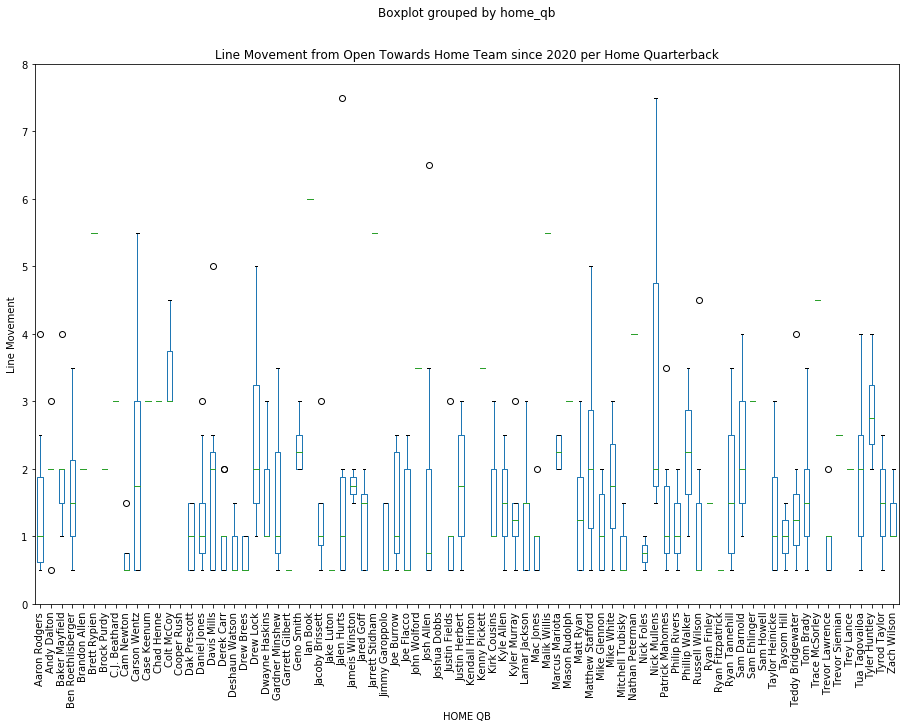

In [28]:
boxplot2 = qbs.boxplot(by = 'home_qb' ,column=['line_movement_from_open'],grid=False,figsize=(15,10)
                     ,rot=90)
boxplot2.set_title('Line Movement from Open Towards Home Team since 2020 per Home Quarterback')
boxplot2.set_xlabel('HOME QB')
boxplot2.set_ylabel('Line Movement')
boxplot2.set_ylim(0,8)
plt.savefig('/dsa/groups/capstonesp2023/online/Team05/Line_Movement_from_Open_Towards_Home_Team_since2020_per_Home_QB.png')

In [29]:
if(connection):
    cursor.close()
    connection.close()
    print("PostgreSQL connection is closed")

PostgreSQL connection is closed
